# PPProjecct

## Data

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train_cache.csv')
train.head()

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,712511,386627.74,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
1,709311,388112.33,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
2,712464,386384.72,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
3,711226,387053.72,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
4,710919,387191.78,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769


In [3]:
test = pd.read_csv('test_cache.csv')
test.head()

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,21483,613944.00,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
1,21354,610190.00,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
2,20883,613910.75,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
3,21493,610052.62,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
4,21473,606866.62,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065


In [ ]:
pd.unique(train[['block_size']]. values.ravel())

array([  8,  16,  32,  64, 256,   4, 128])

In [ ]:
pd.unique(train[['n_jobs']]. values.ravel()).size

32

In [ ]:
pd.unique(train[['iodepth']]. values.ravel()).size

16

In [ ]:
pd.unique(train[['read_fraction']]. values.ravel()).size

101

In [ ]:
pd.unique(train[['io_type']]. values.ravel())

array(['read', 'write'], dtype=object)

In [ ]:
pd.unique(train[['id']]. values.ravel()).size

408

In [4]:
test['io_type_num'] = test['io_type'] == 'write'

In [5]:
test.io_type_num = test.io_type_num.replace({ True : 1 , False : 0 })

In [6]:
y_test = torch.tensor(test[['iops', 'lat']].values)

In [7]:
X_test = torch.tensor(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [8]:
train['io_type_num'] = train['io_type'] == 'write'

In [9]:
train.io_type_num = train.io_type_num.replace({ True : 1 , False : 0 })

In [10]:
y_tr = torch.tensor(train[['iops', 'lat']].values)

In [11]:
X_tr = torch.tensor(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

## Graphs

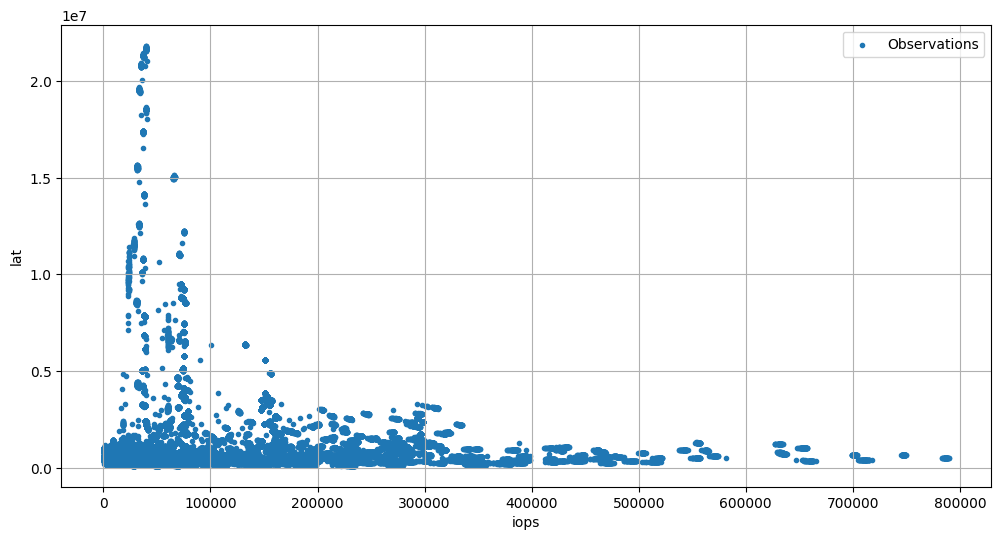

In [12]:
plt.figure(figsize=(12, 6))
plt.scatter(y_tr[:, 0], y_tr[:, 1], marker='.', label='Observations', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Scalers

In [95]:
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np
from dataclasses import dataclass

# from https://github.com/HEPML-AnomalyDetection/CATHODE/blob/4e96989296193da18508710afbfa3b37fffe5952/data_handler.py
def logit_transform_inverse(data, datamin, datamax):
    dataout = (datamin + datamax*np.exp(data))/(1 + np.exp(data))
    return dataout

def quick_logit(x, x_min, x_max, eps):
    x_norm = (x-x_min)/(x_max-x_min)
    x_norm = x_norm[((x_norm != 0) & (x_norm != 1)).all(axis=1)]
    x_norm[x_norm == 0] += eps
    x_norm[x_norm == 1] -= eps
    logit = np.log(x_norm/(1-x_norm))
    logit = logit[~np.isnan(logit).any(axis=1)]
    return logit

class LogitScaler(TransformerMixin, BaseEstimator):

    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.x_max = None
        self.x_min = None

    def fit(self, X, y=None):
        self.x_min = np.min(X, axis=0) - self.eps
        self.x_max = np.max(X, axis=0) + self.eps
        return self

    def transform(self, X):
        return quick_logit(X, self.x_min, self.x_max, self.eps)

    def inverse_transform(self, X):
        return logit_transform_inverse(X, self.x_min, self.x_max)

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.1), StandardScaler())

In [97]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-95-bb35ed73ac8a>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [98]:
stscaler = StandardScaler()

In [99]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

## Model

In [ ]:
!pip install probaforms

In [100]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.01, n_epochs=50)

In [101]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

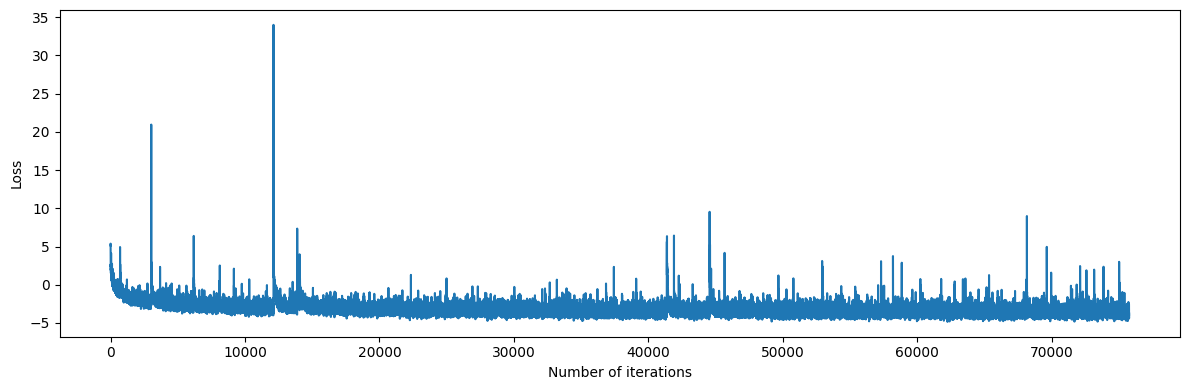

In [102]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [107]:
# samples
y_gen = model.sample(X_test_ss)

In [108]:
scaler.inverse_transform(y_gen)

array([[   20157.15989174,   603429.822886  ],
       [   23689.88493242,   658759.43064012],
       [   28839.69452382,   675432.59178954],
       ...,
       [   35724.59502757, 14306920.07522587],
       [   37629.22863344, 15071817.66816569],
       [   37586.38188704, 15062892.5456213 ]])

In [109]:
y_gen_ss = scaler.inverse_transform(y_gen)

## Generated samples

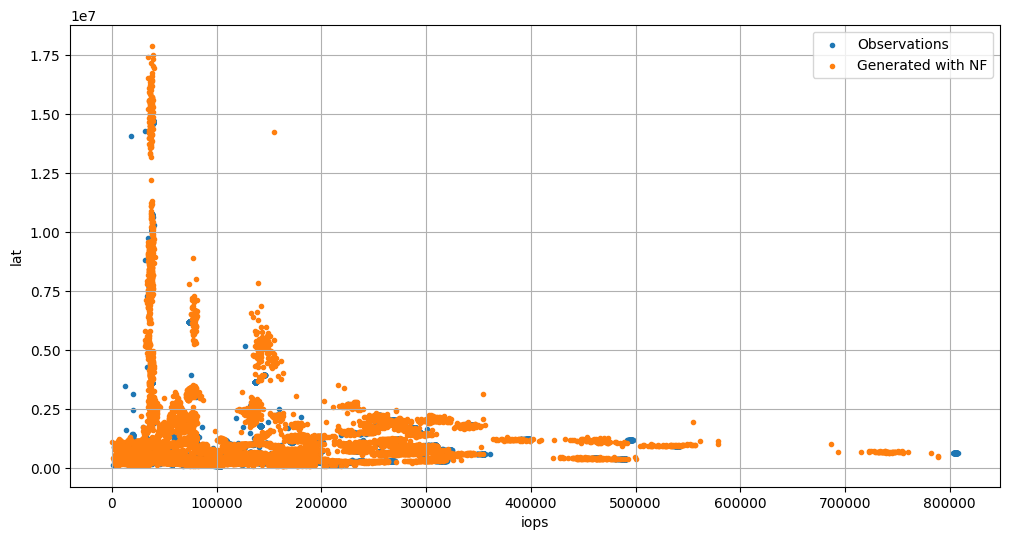

In [110]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Some samples

### 1

In [111]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [112]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [114]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [116]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

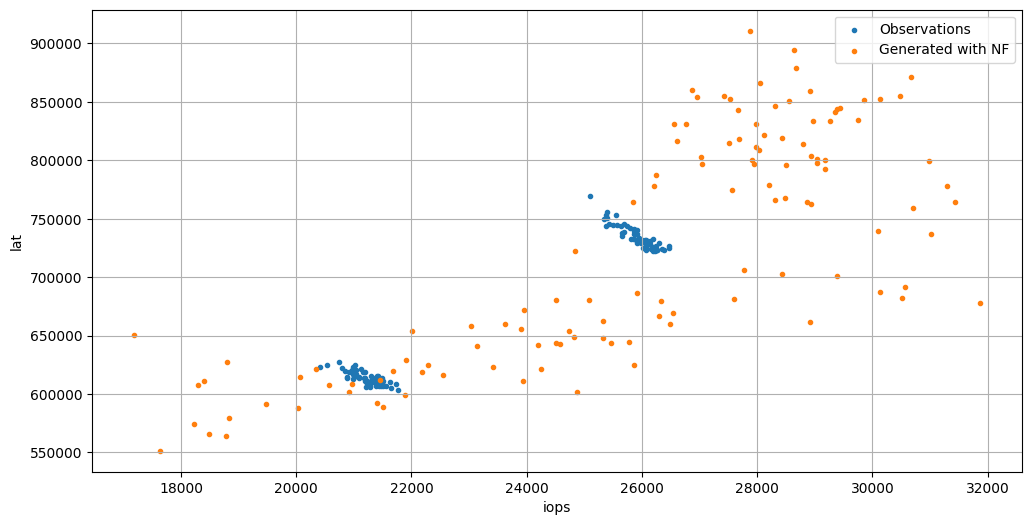

In [117]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### 2

In [ ]:
pd.unique(test[['id']]. values.ravel())

In [118]:
y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-212616-z36709'][['iops', 'lat']].values)
X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-212616-z36709'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [119]:
y_gen_2 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [120]:
y_gen_2 = scaler.inverse_transform(y_gen_2)

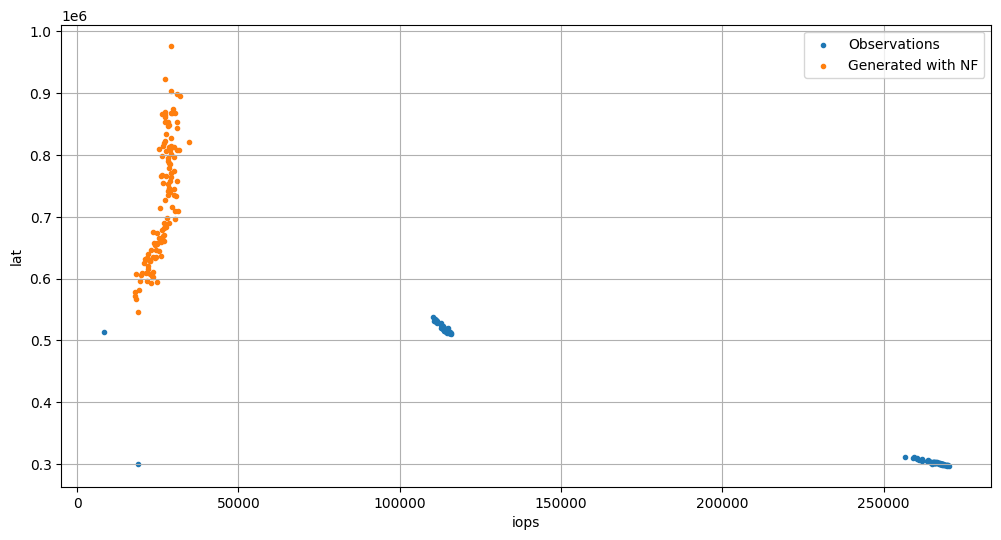

In [121]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_2[:, 0], y_test_2[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_2[:, 0], y_gen_2[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Another model

In [127]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.1), StandardScaler())

In [128]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-95-bb35ed73ac8a>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [129]:
stscaler = StandardScaler()

In [130]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [131]:
from probaforms.models import RealNVP

# model
model = RealNVP(lr=0.01, n_epochs=100)

In [132]:
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

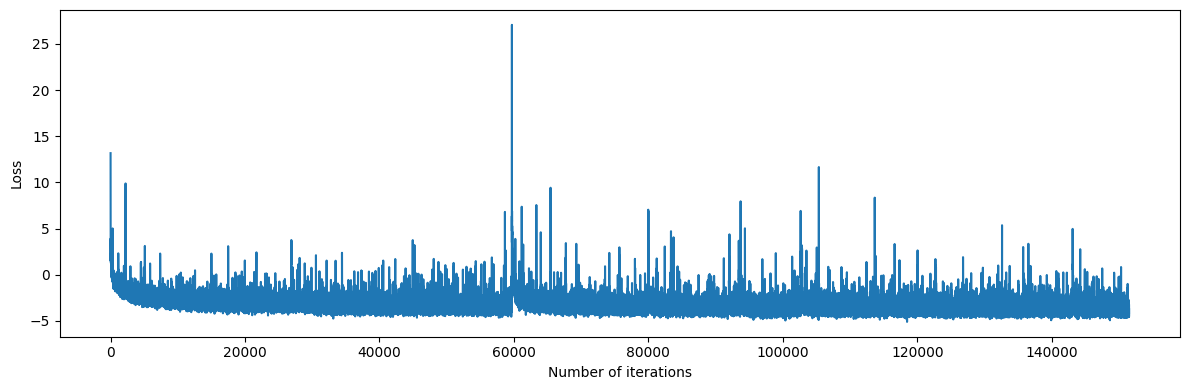

In [133]:
plt.figure(figsize=(12,4))
plt.plot(model.loss_history)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [134]:
# samples
y_gen = model.sample(X_test_ss)

In [135]:
scaler.inverse_transform(y_gen)

array([[   17513.59434164,   553774.99399921],
       [   16686.16861124,   565539.99706364],
       [   21254.68888716,   568133.16164183],
       ...,
       [   39827.55564894, 13529266.42293231],
       [   38908.05216522, 14344408.67161573],
       [   38972.84451117, 14096112.2715898 ]])

In [136]:
y_gen_ss = scaler.inverse_transform(y_gen)

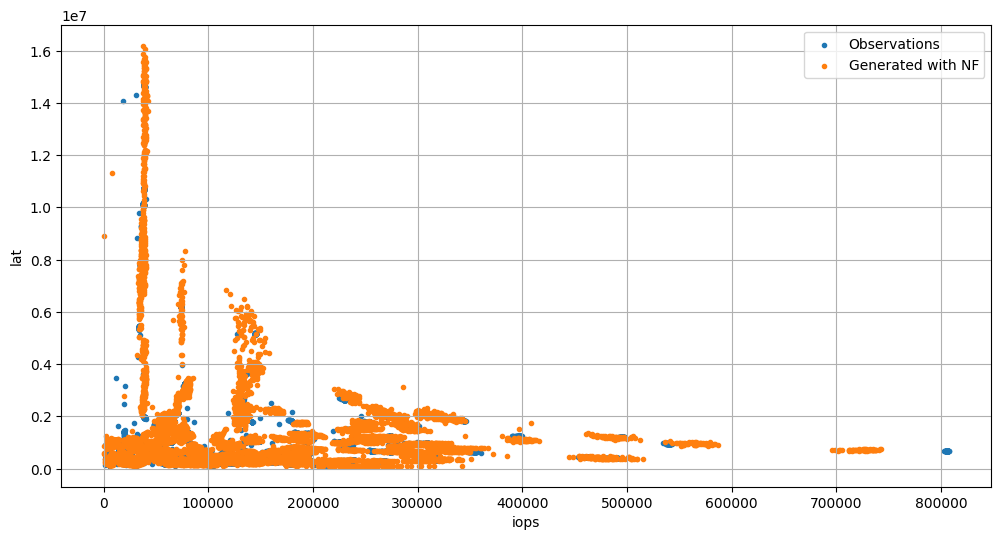

In [137]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test[:, 0], y_test[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_ss[:, 0], y_gen_ss[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Some samples

### 1

In [ ]:
y_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)

In [ ]:
X_test_1 = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_1 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_1 = scaler.inverse_transform(y_gen_1)

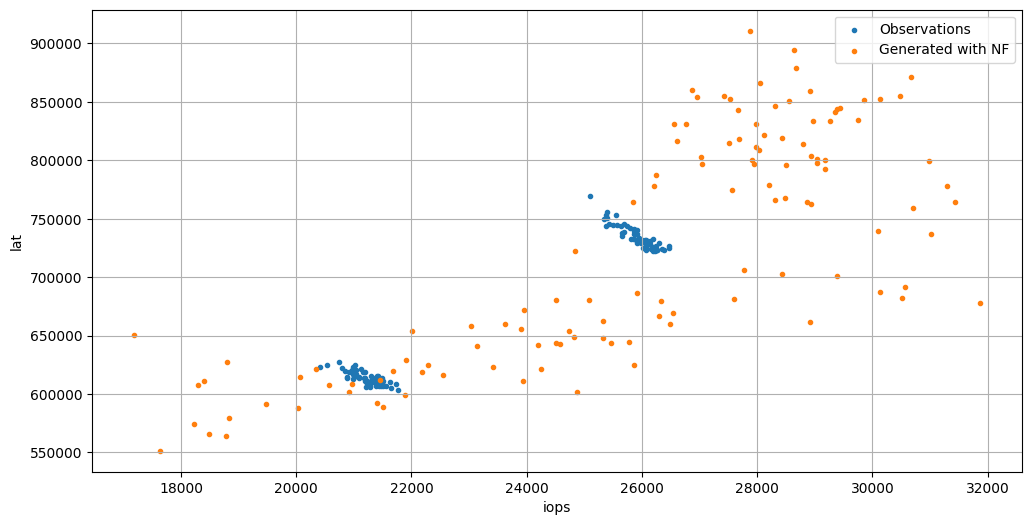

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_1[:, 0], y_test_1[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_1[:, 0], y_gen_1[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

### 2

In [ ]:
pd.unique(test[['id']]. values.ravel())

In [ ]:
y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-212616-z36709'][['iops', 'lat']].values)
X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-212616-z36709'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
y_gen_2 = model.sample(stscaler.transform(X_test_1.clone().detach()))

In [ ]:
y_gen_2 = scaler.inverse_transform(y_gen_2)

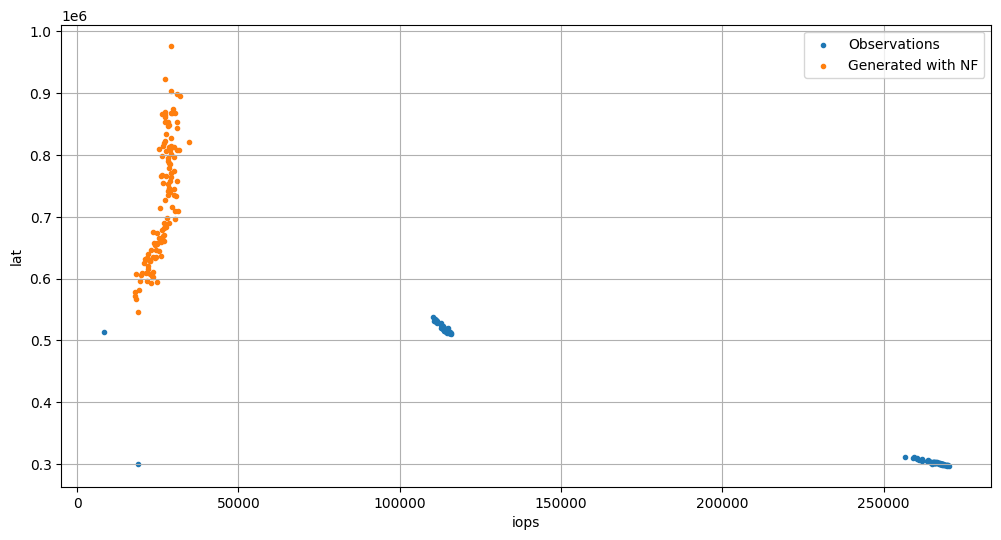

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(y_test_2[:, 0], y_test_2[:, 1], marker='.', label='Observations', linewidth=1)
plt.scatter(y_gen_2[:, 0], y_gen_2[:, 1], marker='.', label='Generated with NF', color='C1', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()